# TEL329 Proyecto Grupo 6 (TeloParkeoIoT) 2024-2

## Profesor: Mohamed Ahmed
## Ayudante: Francisca Soto
##


##### Integrantes: Lucas Navarro - Jonathan Pedraza - Vicente Tejos 


## Simulación (Consumo Energetico)

| **Componente**            | **Estado**               | **Consumo (mW)** | **Notas/Referencia**                                                                 |
|----------------------------|--------------------------|------------------|-------------------------------------------------------------------------------------|
| **Heltec LoRa 32**         | **Transmisión Wi-Fi**    | ~130             | En transmisión a potencia media (13-17 dBm).                                        |
|                            | **Reposo**              | ~10              | Modo de bajo consumo o Deep Sleep.                                                 |
|                            | **Recepción Wi-Fi**     | ~100             | Al recibir paquetes de datos vía Wi-Fi.                                            |
| **Raspberry Pi 4**         | **Transmisión Wi-Fi**    | ~1500            | Durante transmisión de datos por Wi-Fi (puede variar según el tamaño de los datos).|
|                            | **Reposo**              | ~100             | Sin carga significativa o periféricos conectados.                                  |
|                            | **Sleep (simulado)**    | ~50              | Baja potencia simulada apagando periféricos y bajando la frecuencia del CPU.       |
| **Raspberry Pi Camera**    | **Captura de Fotos**     | ~250             | Durante la captura de imágenes.                                                    |
| **Sensor IR (HC-SR501)**   | **Activo**              | ~0.1             | Detección constante en modo normal.                                                |
|                            | **Inactivo**            | ~0.05            | En reposo, sin detección de movimiento.                                            |


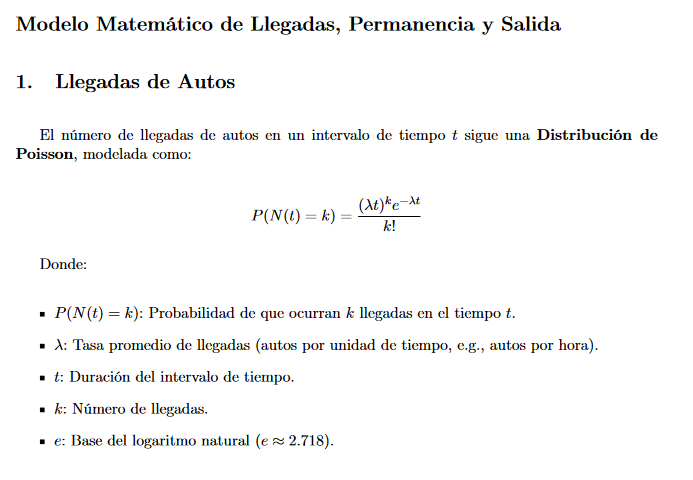
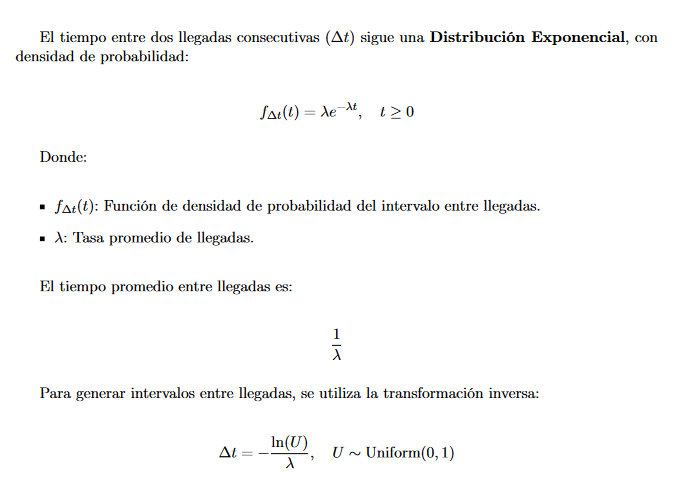
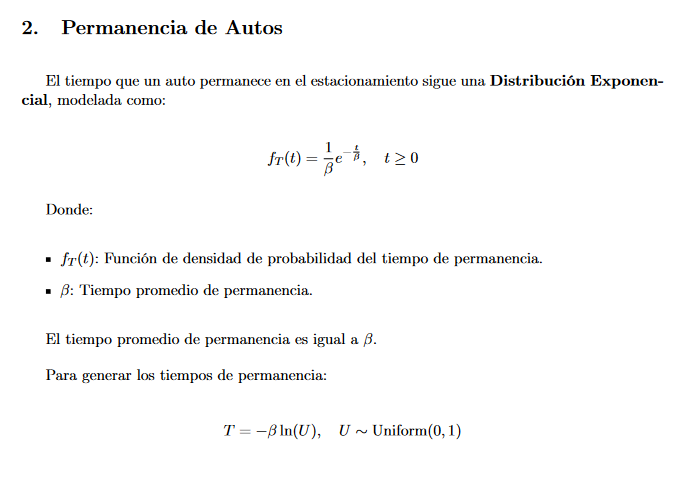
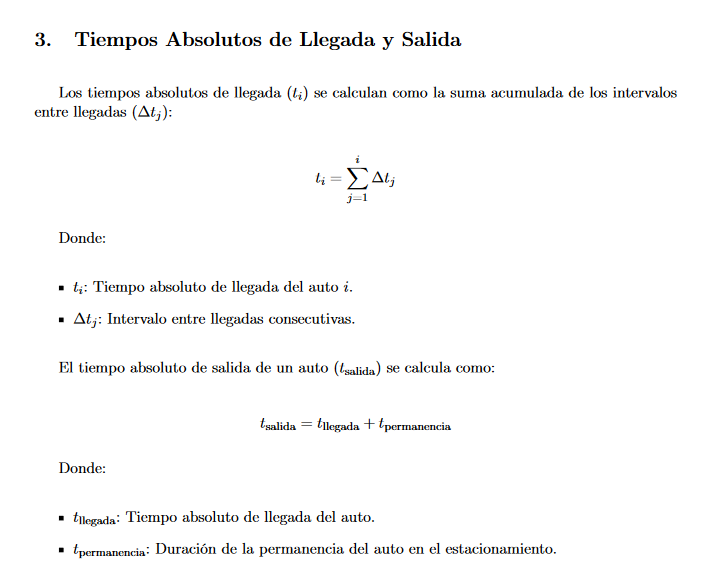
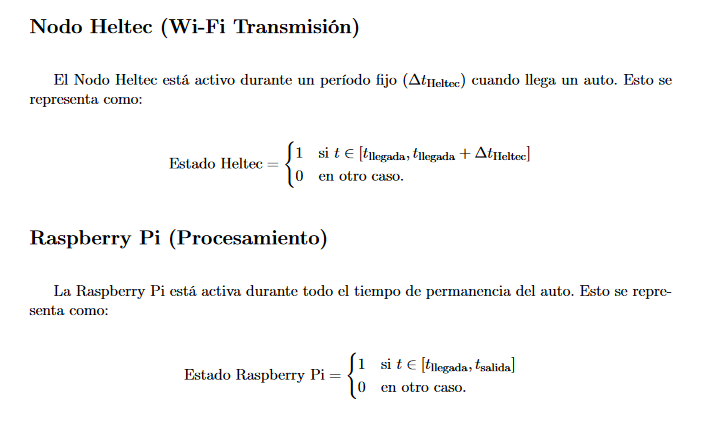

# Simulación con utilización Batería 1000 mAh 

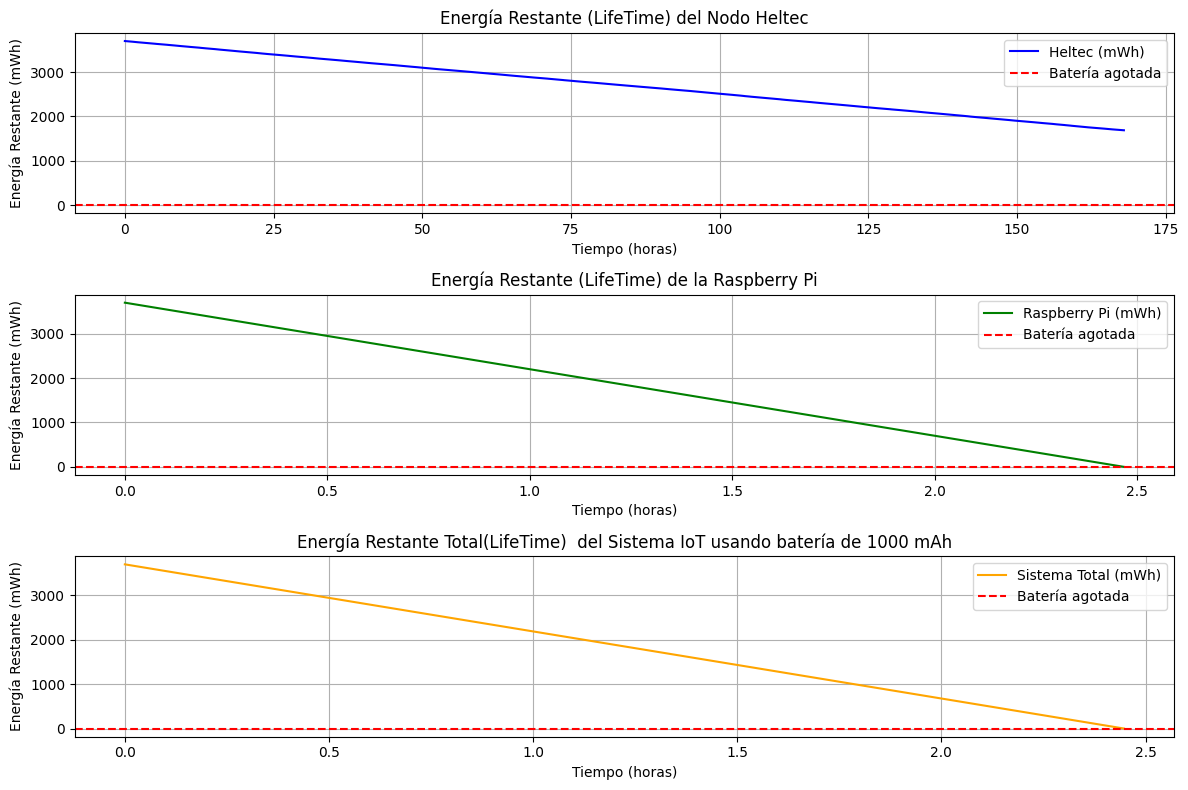

Lifetime es de: 0 días, 2 horas y 26 minutos.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def generar_llegadas(simulation_time, lambda_rate):
    """
    Generar tiempos de llegada de autos utilizando una distribución de Poisson
    y exponencial para los intervalos entre llegadas.
    """
    num_llegadas = np.random.poisson(lambda_rate * (simulation_time / 3600))  # Total de llegadas
    tiempos_de_llegada = np.cumsum(np.random.exponential(3600 / lambda_rate, size=num_llegadas))  # Intervalos
    return tiempos_de_llegada[tiempos_de_llegada < simulation_time]  # Filtrar dentro del tiempo de simulación

def generar_permanencia(tiempos_de_llegada, average_stay_time):
    """
    Generar tiempos de permanencia de autos utilizando una distribución exponencial.
    """
    return np.random.exponential(average_stay_time, size=len(tiempos_de_llegada))

def calcular_salida(tiempos_de_llegada, tiempos_de_permanencia):
    """
    Calcular los tiempos de salida sumando los tiempos de llegada y permanencia.
    """
    return tiempos_de_llegada + tiempos_de_permanencia

def simular_consumo(simulation_time, time_step, tiempos_de_llegada, tiempos_de_salida, 
                    raspberry_active, raspberry_sleep, heltec_active, heltec_idle, ir_sensor):
    """
    Simular el consumo energético del sistema IoT (Heltec + Raspberry Pi).
    """
    time = np.arange(0, simulation_time, time_step)
    heltec_state = np.zeros_like(time)  # Estado del Heltec
    raspberry_state = np.ones_like(time) * raspberry_sleep  # Estado de la Raspberry Pi (por defecto en sueño)

    for llegada, salida in zip(tiempos_de_llegada, tiempos_de_salida):
        llegada_idx = int(llegada)
        salida_idx = int(min(salida, simulation_time - 1))  # Evitar exceder el tiempo de simulación
        heltec_state[llegada_idx:llegada_idx + 10] = 1  # Heltec activo por 10s por cada llegada
        raspberry_state[llegada_idx:salida_idx] = raspberry_active  # Raspberry activa durante la permanencia

    # Calcular el consumo de energía
    heltec_energy = np.where(heltec_state == 1, heltec_active, heltec_idle)
    raspberry_energy = raspberry_state
    total_energy = heltec_energy + raspberry_energy + ir_sensor  # Energía total en mW

    return time, heltec_energy, raspberry_energy, total_energy

def calcular_energia_restante(time, energy, battery_capacity_mWh, time_step):
    """
    Calcular la energía restante en la batería y el tiempo de agotamiento.
    """
    consumed_energy_mWh = np.cumsum(energy * time_step / 3600)  # Energía acumulada en mWh
    battery_remaining_mWh = battery_capacity_mWh - consumed_energy_mWh
    battery_remaining_mWh = np.maximum(battery_remaining_mWh, 0)  # No permitir valores negativos

    battery_depleted_time = np.argmax(battery_remaining_mWh == 0)  # Tiempo de agotamiento
    if battery_depleted_time == 0:
        battery_depleted_time = len(time)  # Si no se agota, usar el tiempo total

    return battery_remaining_mWh[:battery_depleted_time], time[:battery_depleted_time]

# Configuración de la simulación
simulation_time = 7 * 24 * 3600  # 1 semana en segundos
time_step = 1  # Paso de tiempo en segundos
battery_capacity_mWh = 3700  # Capacidad de la batería en mWh
lambda_rate = 6  # Llegadas promedio por hora
average_stay_time = 1.5 * 3600  # Permanencia promedio en segundos

# Consumo energético en mW
heltec_active = 130
heltec_idle = 10
raspberry_active = 1500
raspberry_sleep = 50
ir_sensor = 0.1

# Generar distribuciones
tiempos_de_llegada = generar_llegadas(simulation_time, lambda_rate)
tiempos_de_permanencia = generar_permanencia(tiempos_de_llegada, average_stay_time)
tiempos_de_salida = calcular_salida(tiempos_de_llegada, tiempos_de_permanencia)

# Simular consumo energético
time, heltec_energy, raspberry_energy, total_energy = simular_consumo(
    simulation_time, time_step, tiempos_de_llegada, tiempos_de_salida,
    raspberry_active, raspberry_sleep, heltec_active, heltec_idle, ir_sensor
)

# Calcular energía restante para cada componente
heltec_remaining_mWh, heltec_time = calcular_energia_restante(time, heltec_energy, battery_capacity_mWh, time_step)
raspberry_remaining_mWh, raspberry_time = calcular_energia_restante(time, raspberry_energy, battery_capacity_mWh, time_step)
total_remaining_mWh, total_time = calcular_energia_restante(time, total_energy, battery_capacity_mWh, time_step)

# Graficar resultados
plt.figure(figsize=(12, 8))

# Gráfico 1: Energía restante del Heltec
plt.subplot(3, 1, 1)
plt.plot(heltec_time / 3600, heltec_remaining_mWh, label="Heltec (mWh)", color="blue")
plt.axhline(y=0, color='red', linestyle='--', label="Batería agotada")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Energía Restante (mWh)")
plt.title("Energía Restante (LifeTime) del Nodo Heltec")
plt.legend()
plt.grid()

# Gráfico 2: Energía restante de la Raspberry Pi
plt.subplot(3, 1, 2)
plt.plot(raspberry_time / 3600, raspberry_remaining_mWh, label="Raspberry Pi (mWh)", color="green")
plt.axhline(y=0, color='red', linestyle='--', label="Batería agotada")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Energía Restante (mWh)")
plt.title("Energía Restante (LifeTime) de la Raspberry Pi")
plt.legend()
plt.grid()

# Gráfico 3: Energía restante total del sistema
plt.subplot(3, 1, 3)
plt.plot(total_time / 3600, total_remaining_mWh, label="Sistema Total (mWh)", color="orange")
plt.axhline(y=0, color='red', linestyle='--', label="Batería agotada")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Energía Restante (mWh)")
plt.title("Energía Restante Total(LifeTime)  del Sistema IoT usando batería de 1000 mAh")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("Foto_graph.jpg")
plt.show()




# Tiempo estimado hasta agotamiento
dias = int(total_time[-1] / (3600 * 24))
horas = int((total_time[-1] % (3600 * 24)) / 3600)
minutos = int(((total_time[-1] % (3600 * 24)) % 3600) / 60)
print(f"Lifetime es de: {dias} días, {horas} horas y {minutos} minutos.")


## LifeTime de Heltec con batería de 1000mAh

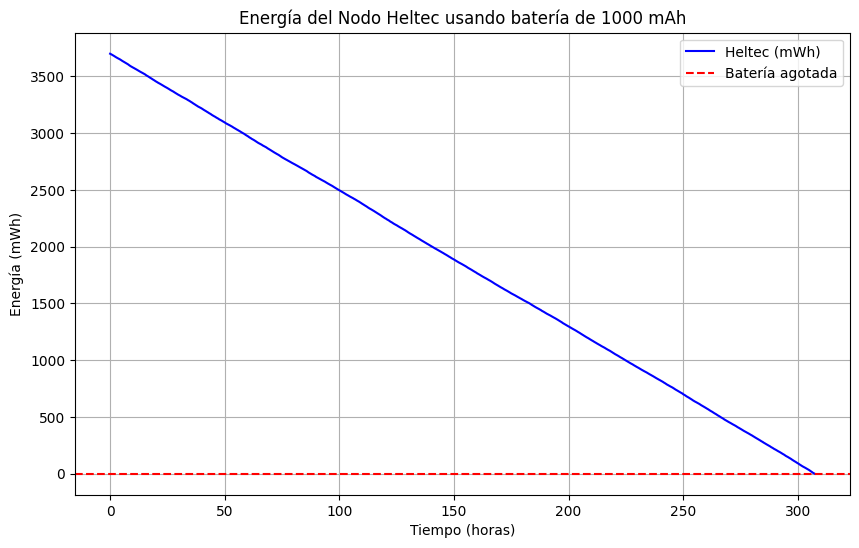

El nodo Heltec durará aproximadamente 12 días, 19 horas y 24 minutos usando la bateria de 3700 mWh


In [35]:
# Configuración de la simulación
simulation_time = 7 * 24 * 3600 *4 # 1 mes en segundos
time_step = 1  # Paso de tiempo en segundos
battery_capacity_mWh = 3700  # Capacidad de la batería en mWh
lambda_rate = 6  # Llegadas promedio por hora
average_stay_time = 1.5 * 3600  # Permanencia promedio en segundos

# Consumo energético del Heltec en mW
heltec_active = 130
heltec_idle = 10

# Generar distribuciones
tiempos_de_llegada = generar_llegadas(simulation_time, lambda_rate)

# Simular consumo energético del Heltec
time, heltec_energy = simular_consumo_heltec(simulation_time, time_step, tiempos_de_llegada, heltec_active, heltec_idle)

# Calcular energía restante para el Heltec
heltec_remaining_mWh, heltec_time = calcular_energia_restante(time, heltec_energy, battery_capacity_mWh, time_step)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(heltec_time / 3600, heltec_remaining_mWh, label="Heltec (mWh)", color="blue")
plt.axhline(y=0, color='red', linestyle='--', label="Batería agotada")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Energía (mWh)")
plt.title("Energía del Nodo Heltec usando batería de 1000 mAh")
plt.legend()

plt.grid()
plt.savefig("Foto_graph_Heltec1000.jpg")
plt.show()

# Tiempo estimado hasta agotamiento del Heltec
dias = int(heltec_time[-1] / (3600 * 24))
horas = int((heltec_time[-1] % (3600 * 24)) / 3600)
minutos = int(((heltec_time[-1] % (3600 * 24)) % 3600) / 60)
print(f"El nodo Heltec durará aproximadamente {dias} días, {horas} horas y {minutos} minutos usando la bateria de 3700 mWh")



## Solucionando del consumo energetico para la Raspberry Pi 4 (30000 mWh)

[Baseus Star-Lord Batería Externa 30000mAh - BestMart](https://bestmart.cl/products/baseus-star-lord-bateria-externa-30000mah-30w-negro?srsltid=AfmBOoriQctl5h6qmXNBAizPdcqzQiuJq8--_K6D_AUW2JUdZ2Fsy5Vw)


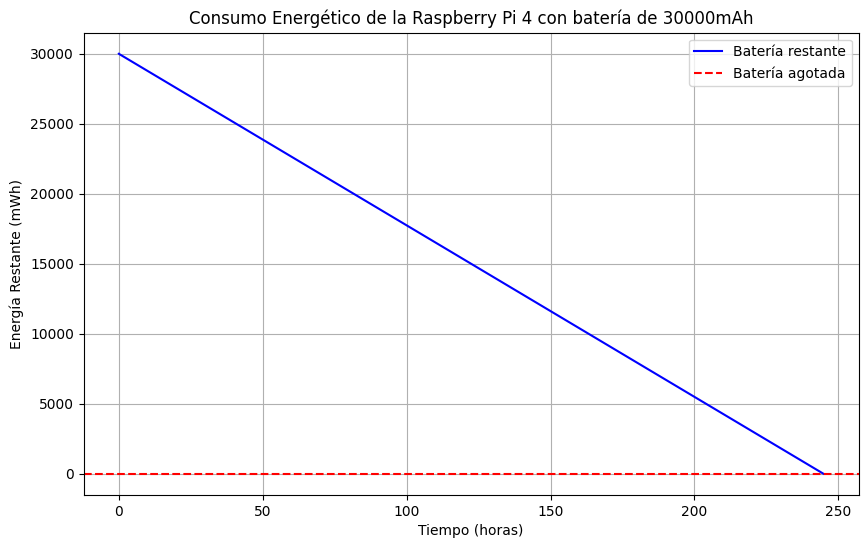

La batería de 30000 mWh durará aproximadamente 10 días, 4 horas y 50 minutos.


In [23]:
# Configuración de la simulación
simulation_time = 24 * 3600 *7 *4 *12 # Simulación de 24 horas en segundos
time_step = 1  # Paso de tiempo en segundos
time = np.arange(0, simulation_time, time_step)

# Consumo energético en mW
raspberry_active = 1500  # Transmisión Wi-Fi activa (mW)
raspberry_idle = 100     # Reposo con periféricos mínimos (mW)
raspberry_sleep = 50     # Modo de baja potencia simulado (mW)

# Capacidad total de la batería en mWh
battery_capacity_mWh = 30000  # Ejemplo con una batería de 30000 mAh a 5V

# Configuración de los estados
transmission_interval = 600  # Cada 10 minutos (600 segundos) la Raspberry transmite
transmission_duration = 30   # La transmisión dura 30 segundos

# Estados de la Raspberry Pi
raspberry_state = np.ones_like(time) * raspberry_idle  # Por defecto en reposo

for t in range(0, simulation_time, transmission_interval):
    raspberry_state[t:t + transmission_duration] = raspberry_active  # Períodos activos de transmisión
    raspberry_state[t + transmission_duration:t + transmission_duration + transmission_interval - 30] = raspberry_sleep  # Simula modo bajo consumo

# Calcular el consumo de energía por segundo
raspberry_energy = raspberry_state  # Energía en mW en cada instante
raspberry_consumed_mWh = np.cumsum(raspberry_energy * time_step / 3600)  # Energía acumulada en mWh

# Energía restante en la batería
battery_remaining_mWh = battery_capacity_mWh - raspberry_consumed_mWh
battery_remaining_mWh = np.maximum(battery_remaining_mWh, 0)  # Asegurarse de que no sea negativa

# Determinar el tiempo hasta que se agote la batería
battery_depleted_time = np.argmax(battery_remaining_mWh == 0)  # Tiempo de agotamiento
if battery_depleted_time == 0:  # Si nunca se agota, usa todo el tiempo
    battery_depleted_time = simulation_time

# Recortar los datos hasta el agotamiento de la batería
time = time[:battery_depleted_time]
raspberry_consumed_mWh = raspberry_consumed_mWh[:len(time)]
battery_remaining_mWh = battery_remaining_mWh[:len(time)]

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(time / 3600, battery_remaining_mWh, label="Batería restante", color="blue")
plt.axhline(y=0, color='red', linestyle='--', label="Batería agotada")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Energía Restante (mWh)")
plt.title("Consumo Energético de la Raspberry Pi 4 con batería de 30000mAh")
plt.legend()
plt.grid()
plt.savefig("Foto_graphRasp_30000.jpg")
plt.show()

# Mostrar tiempo estimado hasta el agotamiento de la batería

dias = int((time[-1] / (3600 * 24)))
horas = int((time[-1] % (3600 * 24)) / 3600)
minutos = int(((time[-1] % (3600 * 24)) % 3600) / 60)
print(f"La batería de 30000 mWh durará aproximadamente {dias} días, {horas} horas y {minutos} minutos.")


# Comparación LORA vs WIFI

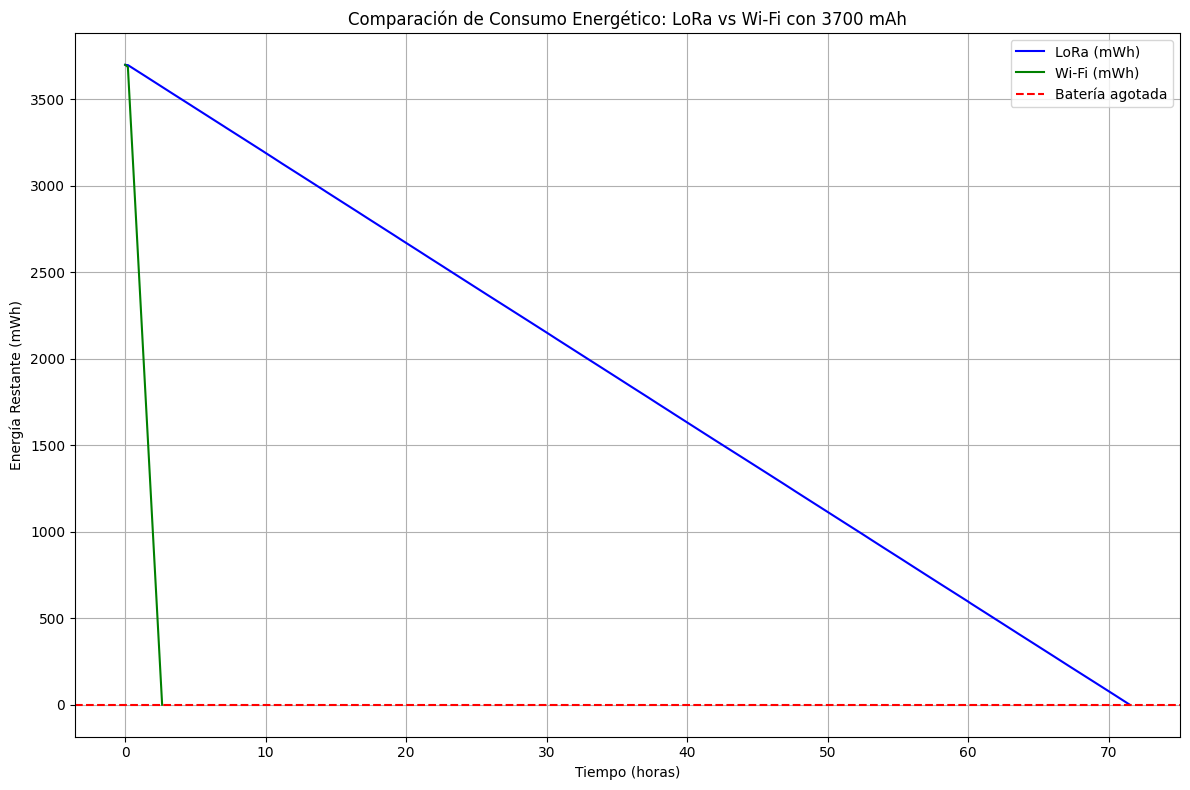

Duración de la batería con LoRa: 2 días, 23 horas.
Duración de la batería con Wi-Fi: 0 días, 2 horas.


In [33]:
# Configuración de la simulación
simulation_time = 7 * 24 * 3600 *4 *12 # 1 semana en segundos
time_step = 1
battery_capacity_mWh = 3700  # Batería de 1000 mAh con 3.7V

lambda_rate = 6
average_stay_time = 1.5 * 3600

# Consumo energético (LoRa)
lora_heltec_active = 50
lora_heltec_idle = 1
lora_raspberry_active = 50
lora_raspberry_sleep = 5
ir_sensor = 0.1

# Consumo energético (Wi-Fi)
wifi_heltec_active = 130
wifi_heltec_idle = 10
wifi_raspberry_active = 1500
wifi_raspberry_sleep = 50

# Generar distribuciones
tiempos_de_llegada = generar_llegadas(simulation_time, lambda_rate)
tiempos_de_permanencia = generar_permanencia(tiempos_de_llegada, average_stay_time)
tiempos_de_salida = calcular_salida(tiempos_de_llegada, tiempos_de_permanencia)

# Simular LoRa
time, lora_heltec_energy, lora_raspberry_energy, lora_total_energy = simular_consumo(
    simulation_time, time_step, tiempos_de_llegada, tiempos_de_salida,
    lora_raspberry_active, lora_raspberry_sleep, lora_heltec_active, lora_heltec_idle, ir_sensor
)

lora_remaining_mWh, lora_time = calcular_energia_restante(time, lora_total_energy, battery_capacity_mWh, time_step)

# Simular Wi-Fi
time, wifi_heltec_energy, wifi_raspberry_energy, wifi_total_energy = simular_consumo(
    simulation_time, time_step, tiempos_de_llegada, tiempos_de_salida,
    wifi_raspberry_active, wifi_raspberry_sleep, wifi_heltec_active, wifi_heltec_idle, ir_sensor
)

wifi_remaining_mWh, wifi_time = calcular_energia_restante(time, wifi_total_energy, battery_capacity_mWh, time_step)

# Graficar comparación
plt.figure(figsize=(12, 8))

# LoRa
plt.plot(lora_time / 3600, lora_remaining_mWh, label="LoRa (mWh)", color="blue")

# Wi-Fi
plt.plot(wifi_time / 3600, wifi_remaining_mWh, label="Wi-Fi (mWh)", color="green")

plt.axhline(y=0, color='red', linestyle='--', label="Batería agotada")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Energía Restante (mWh)")
plt.title("Comparación de Consumo Energético: LoRa vs Wi-Fi con 3700 mAh")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("Foto_graphLoravsWIFI.jpg")
plt.show()

# Resultados
lora_dias = int(lora_time[-1] / (3600 * 24))
lora_horas = int((lora_time[-1] % (3600 * 24)) / 3600)
wifi_dias = int(wifi_time[-1] / (3600 * 24))
wifi_horas = int((wifi_time[-1] % (3600 * 24)) / 3600)

print(f"Duración de la batería con LoRa: {lora_dias} días, {lora_horas} horas.")
print(f"Duración de la batería con Wi-Fi: {wifi_dias} días, {wifi_horas} horas.")


## Heltec Comparativa Lora Vs WIFI con batería de 1000 mAh

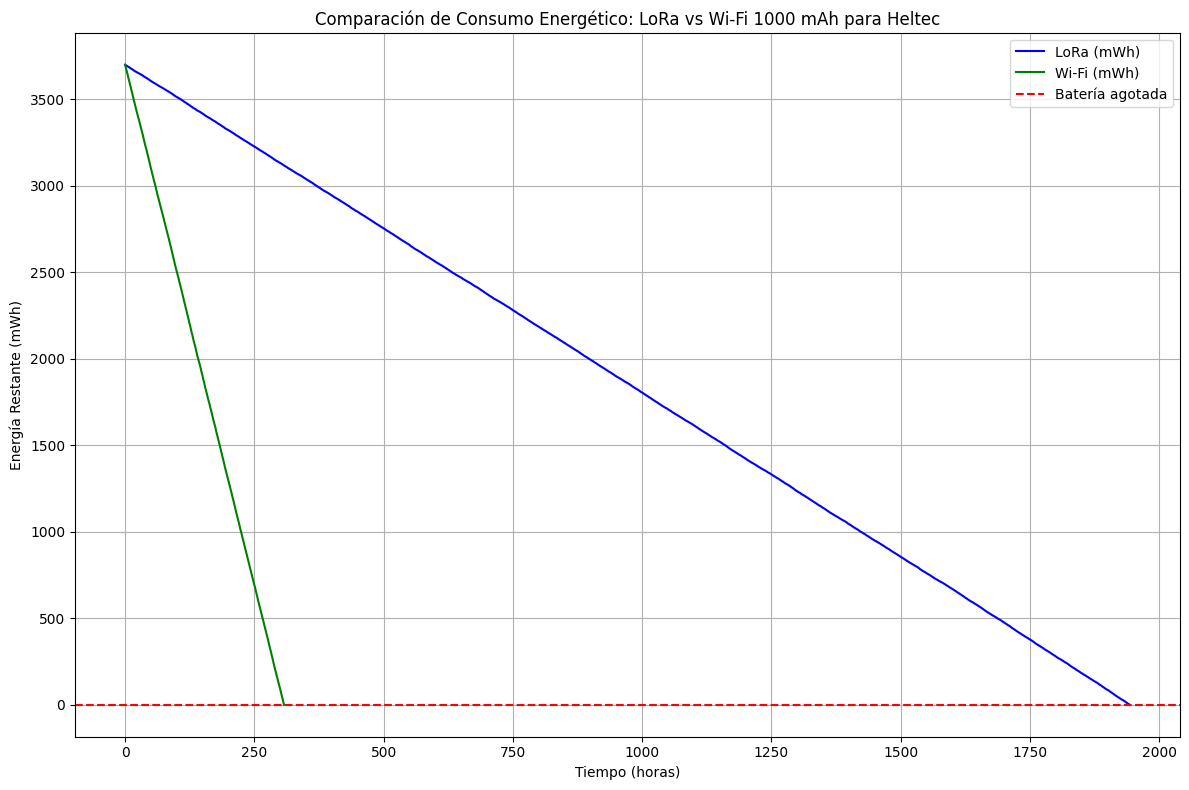

Duración de la batería con LoRa: 80 días, 22 horas.
Duración de la batería con Wi-Fi: 12 días, 19 horas.


In [34]:
# Configuración de la simulación
simulation_time = 7 * 24 * 3600 *4 *12 # 1 semana en segundos
time_step = 1

battery_capacity_mWh = 3700  # Batería de 1000 mAh con 3.7V
lambda_rate = 6
average_stay_time = 1.5 * 3600

# Consumo energético (LoRa)
lora_heltec_active = 50
lora_heltec_idle = 1
lora_raspberry_active = 0
lora_raspberry_sleep = 0
ir_sensor = 0.1

# Consumo energético (Wi-Fi)
wifi_heltec_active = 130
wifi_heltec_idle = 10
wifi_raspberry_active = 0
wifi_raspberry_sleep = 0

# Generar distribuciones
tiempos_de_llegada = generar_llegadas(simulation_time, lambda_rate)
tiempos_de_permanencia = generar_permanencia(tiempos_de_llegada, average_stay_time)
tiempos_de_salida = calcular_salida(tiempos_de_llegada, tiempos_de_permanencia)

# Simular LoRa
time, lora_heltec_energy, lora_raspberry_energy, lora_total_energy = simular_consumo(
    simulation_time, time_step, tiempos_de_llegada, tiempos_de_salida,
    lora_raspberry_active, lora_raspberry_sleep, lora_heltec_active, lora_heltec_idle, ir_sensor
)

lora_remaining_mWh, lora_time = calcular_energia_restante(time, lora_total_energy, battery_capacity_mWh, time_step)

# Simular Wi-Fi
time, wifi_heltec_energy, wifi_raspberry_energy, wifi_total_energy = simular_consumo(
    simulation_time, time_step, tiempos_de_llegada, tiempos_de_salida,
    wifi_raspberry_active, wifi_raspberry_sleep, wifi_heltec_active, wifi_heltec_idle, ir_sensor
)

wifi_remaining_mWh, wifi_time = calcular_energia_restante(time, wifi_total_energy, battery_capacity_mWh, time_step)

# Graficar comparación
plt.figure(figsize=(12, 8))

# LoRa
plt.plot(lora_time / 3600, lora_remaining_mWh, label="LoRa (mWh)", color="blue")

# Wi-Fi
plt.plot(wifi_time / 3600, wifi_remaining_mWh, label="Wi-Fi (mWh)", color="green")

plt.axhline(y=0, color='red', linestyle='--', label="Batería agotada")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Energía Restante (mWh)")
plt.title("Comparación de Consumo Energético: LoRa vs Wi-Fi 1000 mAh para Heltec")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("Foto_graphLoravsWIFI-HELTEC.jpg")
plt.show()

# Resultados
lora_dias = int(lora_time[-1] / (3600 * 24))
lora_horas = int((lora_time[-1] % (3600 * 24)) / 3600)
wifi_dias = int(wifi_time[-1] / (3600 * 24))
wifi_horas = int((wifi_time[-1] % (3600 * 24)) / 3600)

print(f"Duración de la batería con LoRa: {lora_dias} días, {lora_horas} horas.")
print(f"Duración de la batería con Wi-Fi: {wifi_dias} días, {wifi_horas} horas.")
